In [2]:
from supervised_pipeline import *

In [3]:
def train_and_predict_models(X_resampled, y_resampled, X_test, y_test, model_dir="saved_models_3"):
    os.makedirs(model_dir, exist_ok=True)
    results, probas = {}, []
    models = {}

    model_defs = {
        "RandomForest": (RandomForestClassifier(random_state=42, n_jobs=-1), {
            'n_estimators': [100, 200],
            'max_depth': [None, 10]
        }),
        "XGBoost": (XGBClassifier(random_state=36, use_label_encoder=False, eval_metric='logloss', n_jobs=-1), {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2]
        }),
        "Logistic": (LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42), {
            'C': [0.1, 1.0, 10.0]
        }),
        "KNN": (KNeighborsClassifier(n_jobs=-1), {
            'n_neighbors': [3, 5, 7]
        })
    }

    for name, (model, params) in model_defs.items():
        path = os.path.join(model_dir, f"{name}_best_model_3.pkl")

        if os.path.exists(path):
            print(f"\n Loading {name} model from: {path}")
            model_info = joblib.load(path)
            best_model = model_info['model']
            mean_f1 = model_info.get('mean_f1')
            std_f1 = model_info.get('std_f1')

            if mean_f1 is not None and std_f1 is not None:
                print(f"[{name}] (Loaded) Cross-Validation F1-score: Mean = {mean_f1:.4f}, Std = {std_f1:.4f}")

        else:
            print(f"\n Training {name} using GridSearchCV...")
            grid = GridSearchCV(model, params, scoring='f1_macro', cv=5, n_jobs=-1, verbose=1)
            grid.fit(X_resampled, y_resampled)
            best_model = grid.best_estimator_

            mean_f1 = grid.cv_results_['mean_test_score'].mean()
            std_f1 = grid.cv_results_['std_test_score'].mean()
            print(f"[{name}] Cross-Validation F1-score: Mean = {mean_f1:.4f}, Std = {std_f1:.4f}")

            joblib.dump({
                'model': best_model,
                'mean_f1': mean_f1,
                'std_f1': std_f1
            }, path)
            print(f" Saved {name} model to: {path}")

        # Predict & Evaluate
        y_pred = best_model.predict(X_test)
        y_proba = best_model.predict_proba(X_test)[:, 1]
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')

        print(f"\n [{name}] Best Model: {best_model}")
        print(f" [{name}] Test Accuracy: {acc:.4f}")
        print(f" [{name}] Test Macro F1-score: {f1:.4f}")

        results[name] = {
            'model': best_model,
            'accuracy': acc,
            'f1_score': f1,
            'mean_cv_f1': mean_f1,
            'std_cv_f1': std_f1
        }
        models[name] = best_model
        probas.append(y_proba)

        plot_confusion_matrix(y_test, y_pred, labels=[0, 1], title=f"{name} Confusion Matrix")

    return results, probas, models

Loading BERT embeddings from bert_mpnet_embeddings.npy...

 Loading RandomForest model from: saved_models_3\RandomForest_best_model_3.pkl
[RandomForest] (Loaded) Cross-Validation F1-score: Mean = 0.5878, Std = 0.0031

 [RandomForest] Best Model: RandomForestClassifier(n_jobs=-1, random_state=42)
 [RandomForest] Test Accuracy: 0.6577
 [RandomForest] Test Macro F1-score: 0.6022


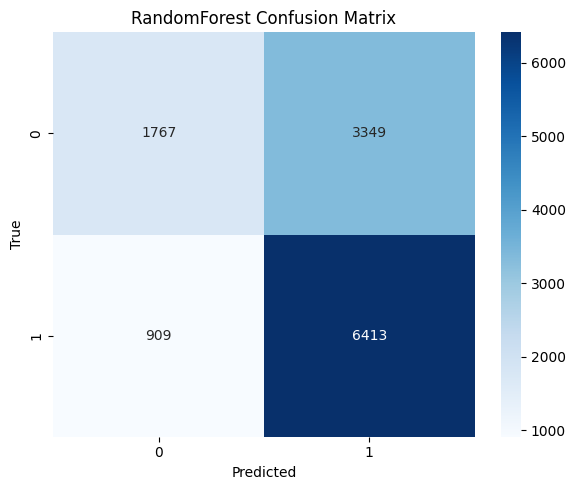


 Loading XGBoost model from: saved_models_3\XGBoost_best_model_3.pkl
[XGBoost] (Loaded) Cross-Validation F1-score: Mean = 0.6577, Std = 0.0042

 [XGBoost] Best Model: XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=7, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=36, reg_alpha=0, reg_lambda=1, ...)
 [XGBoost] Test Accuracy: 0.6940
 [XGBoost] Test Macro F1-score: 0.6721


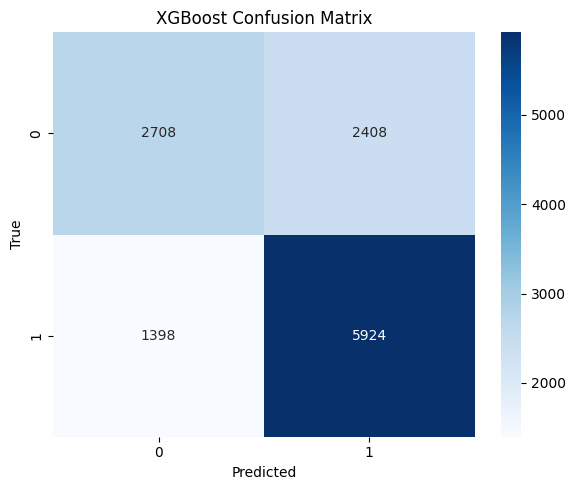


 Loading Logistic model from: saved_models_3\Logistic_best_model_3.pkl
[Logistic] (Loaded) Cross-Validation F1-score: Mean = 0.6571, Std = 0.0039

 [Logistic] Best Model: LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)
 [Logistic] Test Accuracy: 0.6804
 [Logistic] Test Macro F1-score: 0.6536


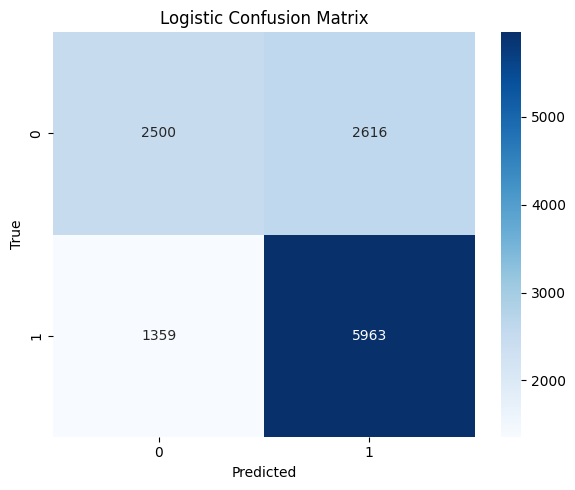


 Loading KNN model from: saved_models_3\KNN_best_model_3.pkl
[KNN] (Loaded) Cross-Validation F1-score: Mean = nan, Std = nan

 [KNN] Best Model: KNeighborsClassifier(n_jobs=-1, n_neighbors=3)
 [KNN] Test Accuracy: 0.6366
 [KNN] Test Macro F1-score: 0.6211


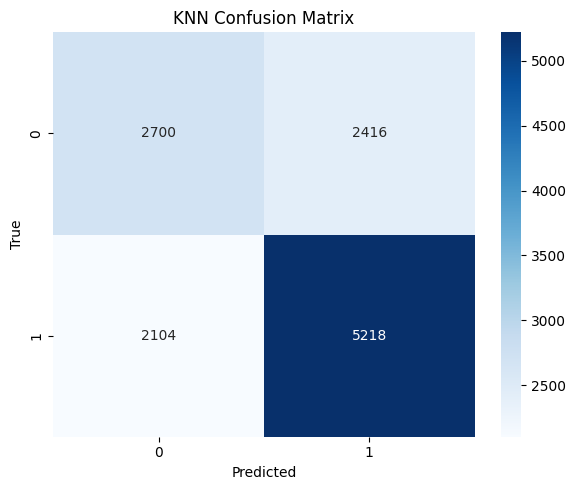

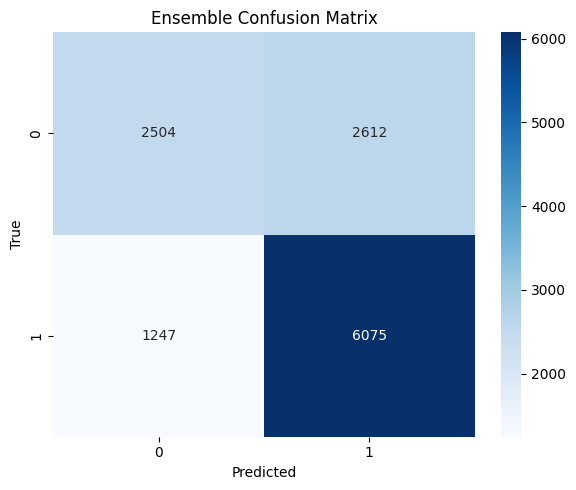


[Ensemble] Accuracy: 0.6897
[Ensemble] Macro F1-score: 0.6619


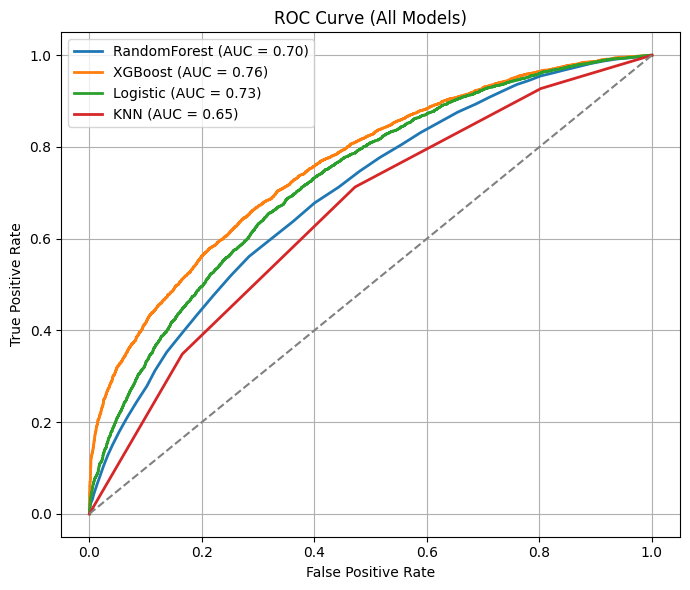

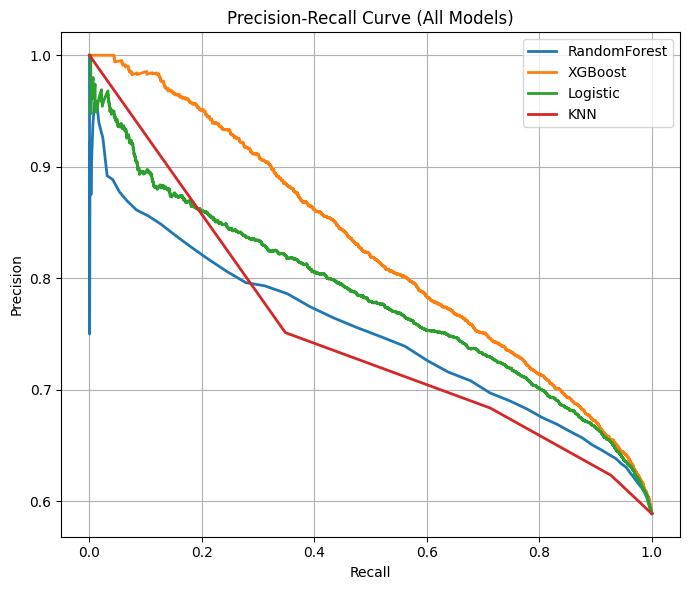

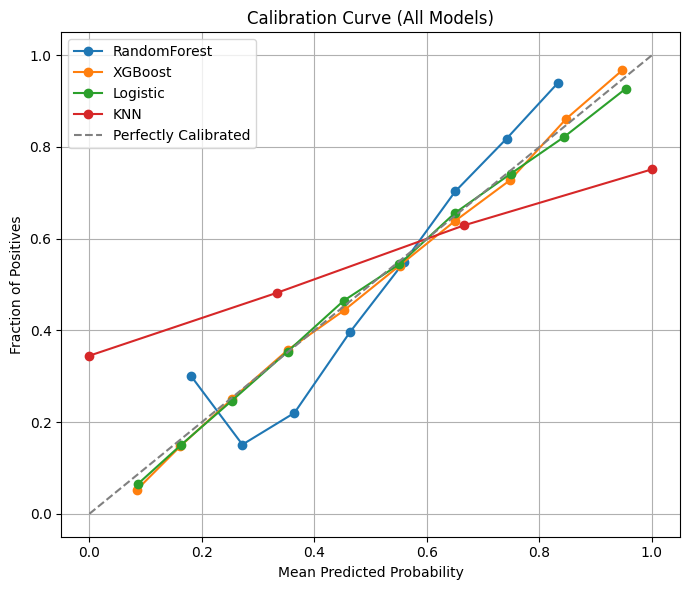

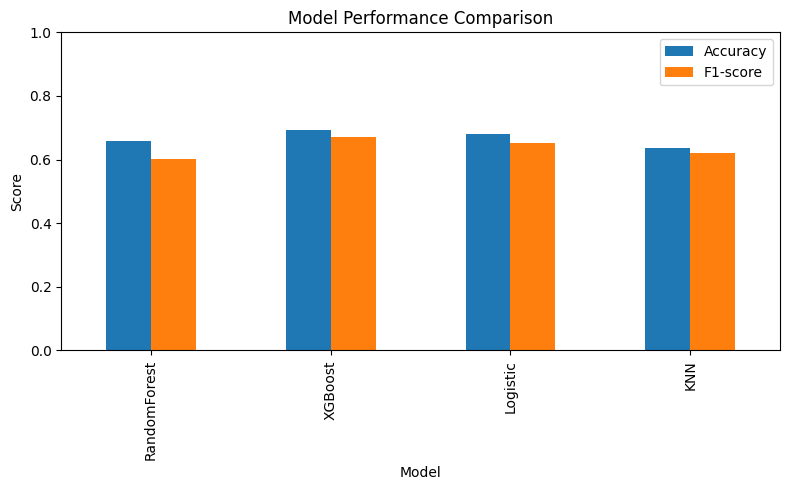


 Showing feature importances for: XGBoost


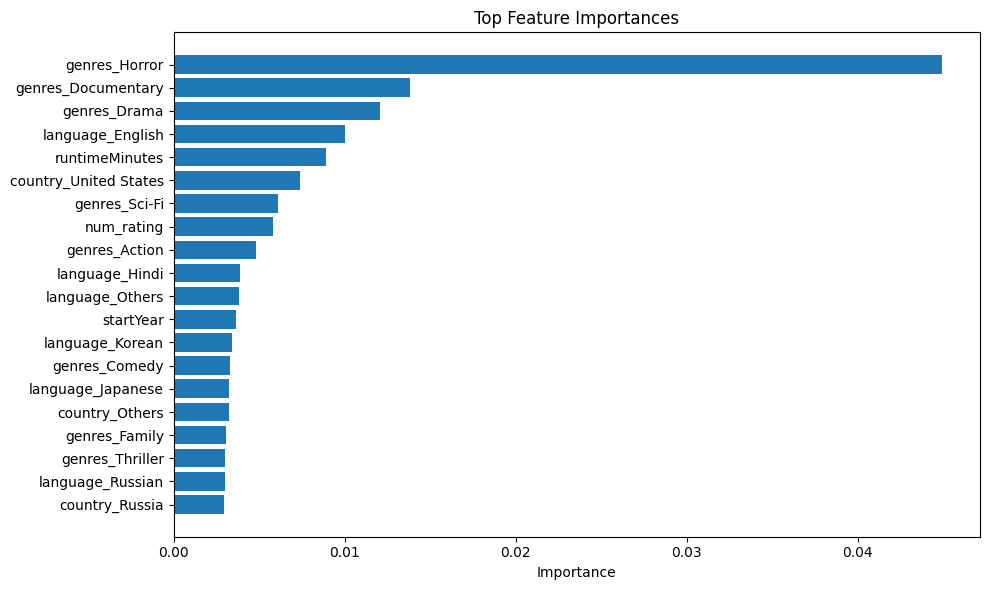


 Showing feature importances for: RandomForest


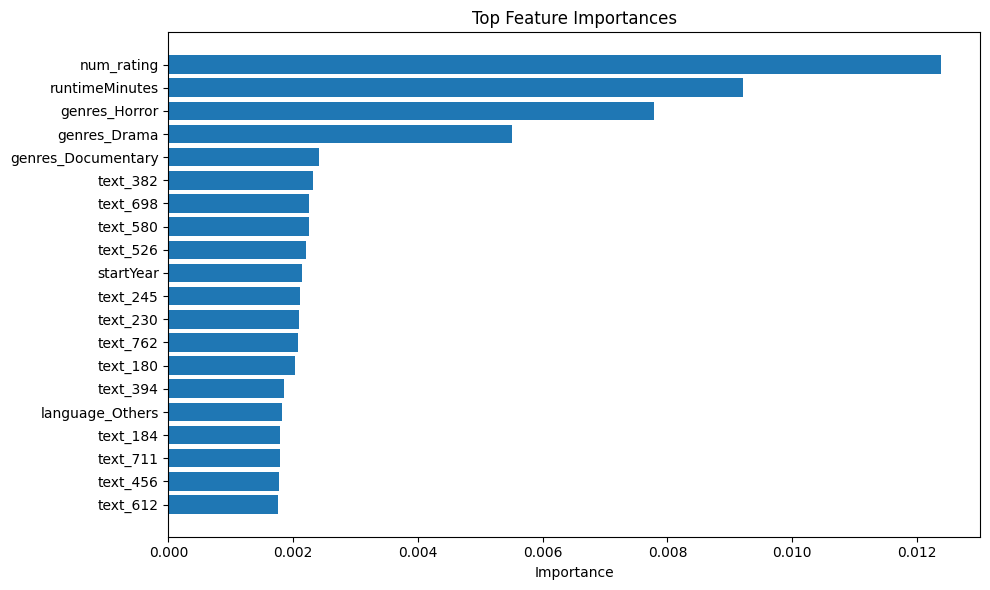


False Negatives (Positive but predicted as negative):
              primaryTitle                                               plot  \
58574             Alcatraz  America's most infamous maximum security priso...   
55405     Husband Material  Rumi and Vicky are love birds where Rumi convi...   
19857      My Summer Story  In this second sequel to A Christmas Story (19...   
5585    Back from Eternity  A South American plane loaded with an assortme...   
30473  Ju-Rei: The Uncanny  Japanese school girls die violently after seei...   

                       genres                        country         language  \
58574  Action,Adventure,Crime  United Kingdom, United States          English   
55405    Comedy,Drama,Romance                          India            Hindi   
19857           Comedy,Family                  United States          English   
5585          Adventure,Drama                  United States  Gaelic, English   
30473                  Horror                        

In [5]:
def main():
    # Load and clean data
    df = load_and_clean_data("../1. Data_preparation/df_final_frozen_62188.csv")
    df = generate_labels(df)

    # Load or generate text embeddings
    X_text = load_or_generate_bert_embeddings(df)

    # Assemble features
    X_all, feature_names = assemble_features(df, X_text)
    y = df['label']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=42, stratify=y)


    # Train models and get predictions
    results, probas, models = train_and_predict_models(X_train, y_train, X_test, y_test)
    ensemble_and_evaluate(y_test, probas)

    # Convert list of probas into a dictionary keyed by model name
    model_names = list(results.keys())
    probas_dict = {model_name: probas[i] for i, model_name in enumerate(model_names)}
    

    # Visualizations for all models
    plot_roc_curve_multi(y_test, probas_dict)
    plot_pr_curve_multi(y_test, probas_dict)
    plot_calibration_curve_multi(y_test, probas_dict)
    plot_model_performance(results)

    tree_models = ["XGBoost", "RandomForest"]
    for name in tree_models:
        model = models.get(name)
        if hasattr(model, "feature_importances_"):
            print(f"\n Showing feature importances for: {name}")
            plot_feature_importance(model, feature_names, top_n=20)


    # XGBoost Misclassification
    model_xgb = models.get("XGBoost")
    if model_xgb:
        y_pred = model_xgb.predict(X_test)
    
        # Reconstruct test data based on original index
        df_test = df.iloc[y_test.index].copy()
        df_test["true"] = y_test.values
        df_test["pred"] = y_pred
    
        # Extracting misclassified samples
        false_negatives = df_test[(df_test["true"] == 1) & (df_test["pred"] == 0)].head(5)
        false_positives = df_test[(df_test["true"] == 0) & (df_test["pred"] == 1)].head(5)
    
        print("\nFalse Negatives (Positive but predicted as negative):")
        print(false_negatives[["primaryTitle", "plot", "genres", "country", "language", "true", "pred"]])
    
        print("\nFalse Positives (Negative but predicted positive):")
        print(false_positives[["primaryTitle", "plot", "genres", "country", "language", "true", "pred"]])






if __name__ == "__main__":
    main()